In [1]:
import pickle
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import datetime
import seaborn as sns

sys.path.append("../")
sys.path.append("../covid19_inference")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19

In [2]:
""" Matplotlib config
"""
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams["figure.figsize"] = [3.4, 2.7]  # APS single column
matplotlib.rcParams["figure.dpi"] = 300  # this primarily affects the size on screen
#matplotlib.rcParams['axes.linewidth'] = 0.3
matplotlib.rcParams["axes.labelcolor"] = "black"
matplotlib.rcParams["axes.edgecolor"] = "black"
matplotlib.rcParams["xtick.color"] = "black"
matplotlib.rcParams["ytick.color"] = "black"
matplotlib.rcParams["xtick.labelsize"] = 8
matplotlib.rcParams["ytick.labelsize"] = 8
matplotlib.rcParams["axes.labelsize"] = 8
matplotlib.rcParams["axes.titlesize"]= 10
matplotlib.rcParams["legend.fontsize"] = 6
matplotlib.rcParams["legend.title_fontsize"] = 8

""" Colors
Done with rcParams / see plot.rcParams
"""


""" General configs
"""
fig_path = "./figures"
# Save figure as pdf and png        
save_kwargs = {
    "transparent":True,
    "dpi":300,
    "bbox_inches":"tight"
}

In [3]:
%load_ext autoreload
%autoreload 2

## Load data/model

In [4]:
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
tune = 1000
draws = 2000
max_treedepth = 12
fstr=(f"/data.nst/jdehning/covid_uefa_traces11/UEFA"+
    f"-beta=False"+
    f"-country=Germany"+
    f"-offset_data=0"+
    f"-draw_delay=True"+
    f"-weighted_alpha_prior=0"+
    f"-prior_delay=-1"+
    f"-width_delay_prior=0.1"+
    f"-sigma_incubation=-1.0"+
    f"-median_width_delay=1.0"+
    f"-interval_cps=10.0"+
    f"-tune={tune}"+
    f"-draws={draws}"+
    f"-max_treedepth={max_treedepth}.pickled")
model, trace = load(fstr)
dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])

FileNotFoundError: [Errno 2] No such file or directory: '/data.nst/jdehning/covid_uefa_traces11/UEFA-beta=False-country=Germany-offset_data=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-interval_cps=10.0-tune=1000-draws=2000-max_treedepth=12.pickled'

In [7]:
def RungeKutta4(dt, f, t, y_t ):
    """
        Performs runge kutta 4 on a function with parameters
        Parameters
        ----------
        dt : number
            size of the timestep
        f : function
            function on which the runge kutta steps should be performed
        t : number
            time
        y : array
            state vector at time t
    """
    k_1 = f(t, y_t)
    k_2 = f(t + dt / 2, y_t + k_1 * dt / 2)
    k_3 = f(t + dt / 2, y_t + k_2 * dt / 2)
    k_4 = f(t + dt, y_t + k_3 * dt)
    return y_t + dt / 6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)

def SEIR(lambda_t, y0, t_max=100, gamma=None, epsilon=None, inf_S_pool=True):
    """
        Calculates the timeseries for the SEIR model by using Runge Kutta 4.
        Parameters
        ----------
        lambda_t : array
            Should be generated by one of the model lambda functions for the right size
        y0 : array
            Initial state vector containing S0,E0,I0,R0
        gamma : number
            Exposed to infectious decay
        epsilon : number
            Infectious to Recovered decay
        Return
        ------
        t , S, E, I, R
    """

    def f(t, y_t):
        """
            Function to compute the SEIR model
            Parameters
            ----------
            t : time t
                not needed but here for consistency in RK4
            y : state_vector
                containing S_t,E_t,I_t,R_t,λ_t
        """
        S = y_t[0]
        E = y_t[1]
        I = y_t[2]
        R = y_t[3]
        λ = y_t[4]

        dS = -λ * S * I / N
        dE = λ * S * I / N - ε * E
        dI = ε * E - γ * I
        dR = γ * I
        if inf_S_pool:
            dS = S_0
        return np.array([dS, dE, dI, dR, 0])
    # ------------------------------------------------------------------------------ #
    # Preliminar parameters
    # ------------------------------------------------------------------------------ #
    λ_t = lambda_t
    S_0 = y0[0]
    E_0 = y0[1]
    I_0 = y0[2]
    R_0 = y0[3]
    N = S_0 + E_0 + I_0 + R_0

    if gamma is None:
        γ = np.random.uniform(0, 1)
    else:
        γ = gamma
    if epsilon is None:
        ε = np.random.uniform(0, 1)
    else:
        ε = epsilon

    # Time array
    t = np.arange(start=0, stop=t_max, step=1)
    # Array for state vectors, already filled for the time 0
    y_t = [np.array([S_0, E_0, I_0, R_0, λ_t[0]])]

    # ------------------------------------------------------------------------------ #
    # Timesteps
    # ------------------------------------------------------------------------------ #
    for i in range(len(t) - 1):  # -1 because we append to an array
        """
        RungeKutta4 returns state vector but the last entry (lambda) has to be 
        discarded
        """
        y_t.append(RungeKutta4(1, f, t[i], y_t[i]))
        y_t[i + 1][4] = λ_t[i + 1]

    y_t = np.array(y_t)
    return t, y_t[:, 0], y_t[:, 1], y_t[:, 2], y_t[:, 3]

Create different models: https://www.nature.com/articles/s41467-021-26013-4.

In [30]:
models = {}

In [33]:
t_max = 60
lambda_t = np.ones(t_max)*0.25
t, S, I, E, R = SEIR(lambda_t, [83129285,3000,0,0],t_max=t_max, gamma=0.1, epsilon=0.2, inf_S_pool=False)
models["mod_0"] = I


lambda_t = np.ones(t_max)*0.3
t, S, I, E, R = SEIR(lambda_t, [83129285,3000,0,0],t_max=t_max, gamma=0.1, epsilon=0.2, inf_S_pool=False)
models["mod_1"] = I

lambda_t = np.ones(t_max)*0.35
t, S, I, E, R = SEIR(lambda_t, [83129285,3000,0,0],t_max=t_max, gamma=0.1, epsilon=0.2, inf_S_pool=False)
models["mod_2"] = I


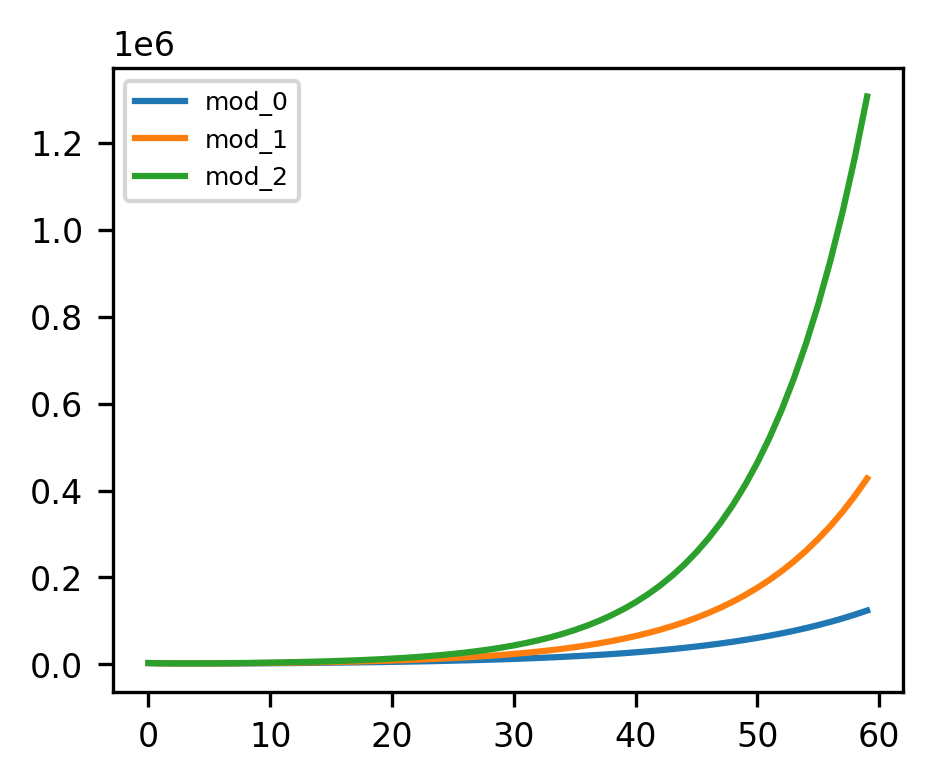

In [34]:
for model in models:
    plt.plot(t,models[model],label=model)
plt.legend()
plt.show()

## Plotting

In [35]:
from covid19_soccer.plot.utils import lighten_color
from matplotlib.colors import to_hex
def effect_mean(ax, labels, y, y_err, colors):
    
    # Plot vertical lines without connection
    lines = ax.vlines(
        x=labels,
        ymin=y-y_err[:,0],
        ymax=y+y_err[:,1],
        lw=3,
        colors=colors
    )
    
    lines.set_capstyle("round")
    # Plot horizontal lines at mean
    ax.scatter(
        x=labels,
        y=y,
        marker="o",
        s=20,
        zorder=10,
        c="white",
        edgecolor=colors,
    )
    
    # Markup
    ax.set_ylabel("$\sum \Delta R$")
    ax.set_xlim(-0.25,len(y)-0.75)
    ax.set_ylim(min(y)-y_err.max(),max(y)+y_err.max())
    ax.set_xticklabels(labels,rotation=45,ha='right')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    return ax

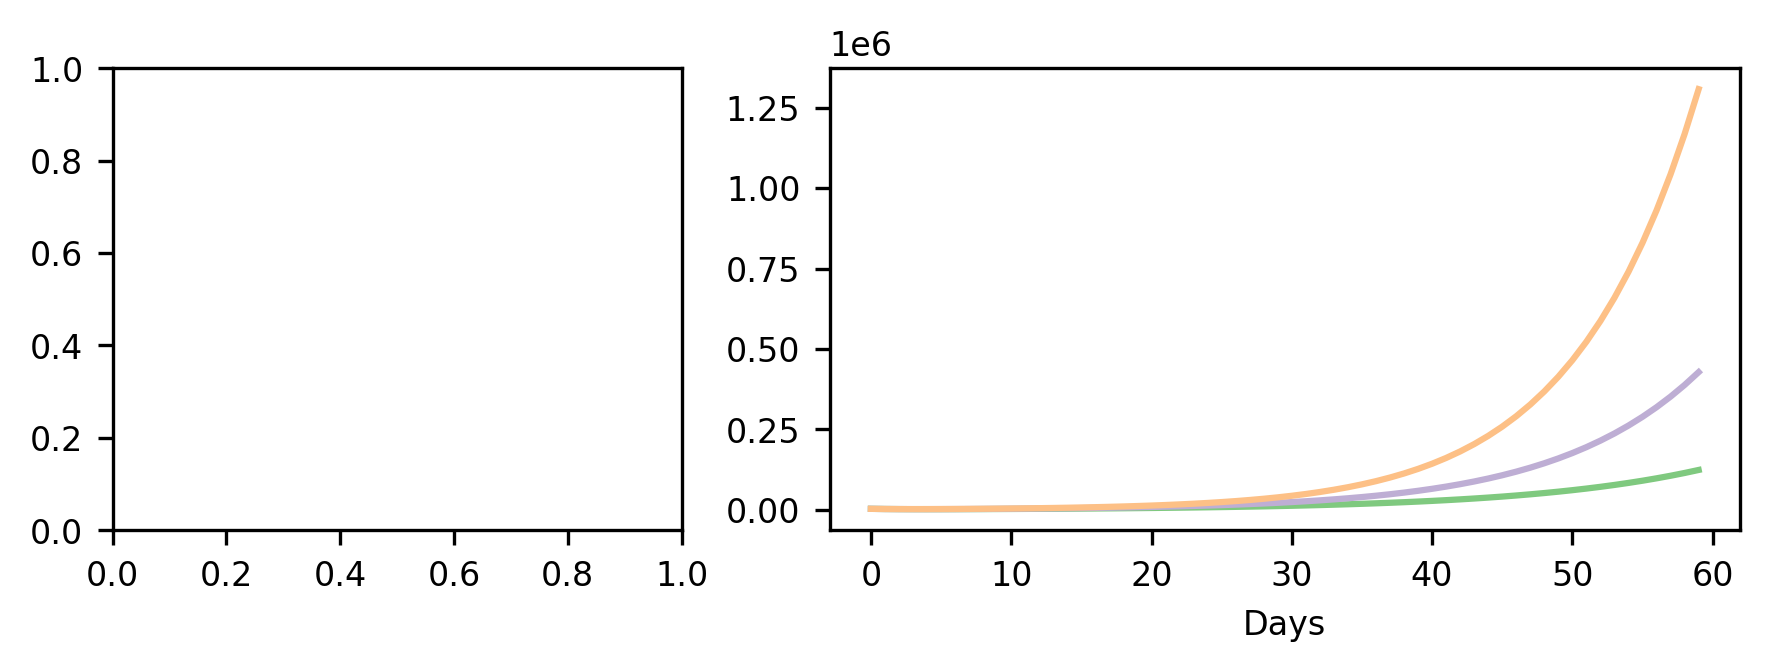

In [43]:
fig, axes = plt.subplots(1,2,figsize=(7,2.0),gridspec_kw={"width_ratios":[0.5,0.8,]})

# Colors
cmap = plt.get_cmap("Accent")
colors = [to_hex(cmap(i),keep_alpha=True) for i in range(len(models))]

# Plotting change in R
labels = ["Soccer","Small\ngathering","Closure of\neducation","Border\nrestriction"]
#lines = effect_mean(axes[0],model_labels,y,y_err,colors)

# Model plots i.e. new cases
for i,model in enumerate(models):
    covid19_soccer.plot.timeseries._timeseries(ax=axes[1],x=t,y=models[model],color=colors[i],what="model",date_format=False)
    
# Markup
axes[1].set_xlabel("Days")


fig.savefig(f"{fig_path}/what_if.pdf", **save_kwargs)
fig.savefig(f"{fig_path}/what_if.png", **save_kwargs)
plt.show()